Yijia Lu
1961366
4/24/ 2023

https://github.com/TClyj/EE-machine-learning-project.git

In [7]:
! pip install tensorflow

Do an SVD analysis of the digit images. You will need to reshape each image into a column vector
and each column of your data matrix is a different image.

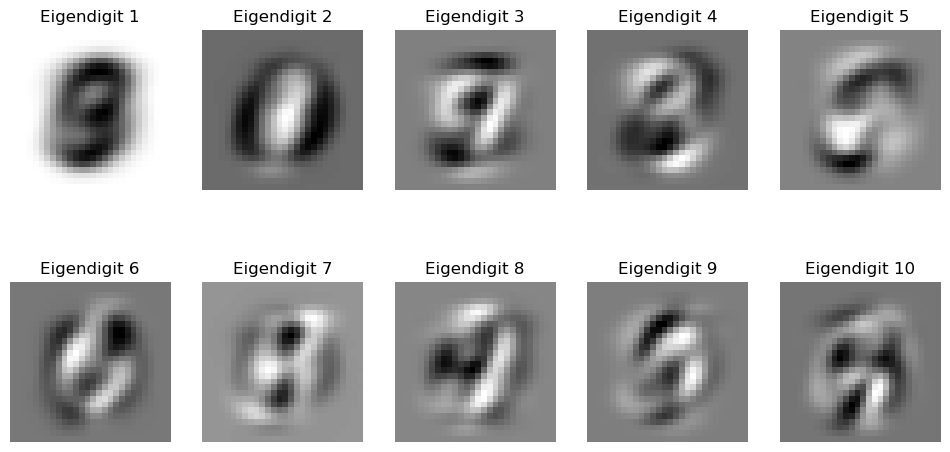

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape each image into a column vector
train_images_flat = train_images.reshape(train_images.shape[0], -1).T
test_images_flat = test_images.reshape(test_images.shape[0], -1).T

#print(train_images_flat.shape)
#print(train_labels.shape)

# Perform SVD on the data matrix
u, s, vh = np.linalg.svd(train_images_flat, full_matrices=False)

#print(vh.shape)

# Visualize the top singular vectors (eigendigits) as images
n_components = 10
plt.figure(figsize=(12, 6))
for i in range(n_components):
    plt.subplot(2, 5, i+1)
    plt.imshow(u[:, i].reshape(28, 28), cmap='gray')
    plt.title(f'Eigendigit {i+1}')
    plt.axis('off')
plt.show()

What does the singular value spectrum look like and how many modes are necessary for good
image reconstruction? (i.e. what is the rank r of the digit space?)

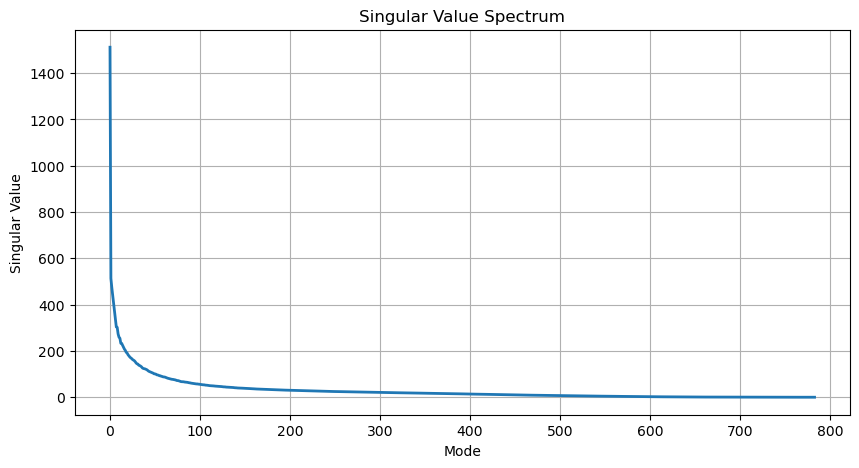

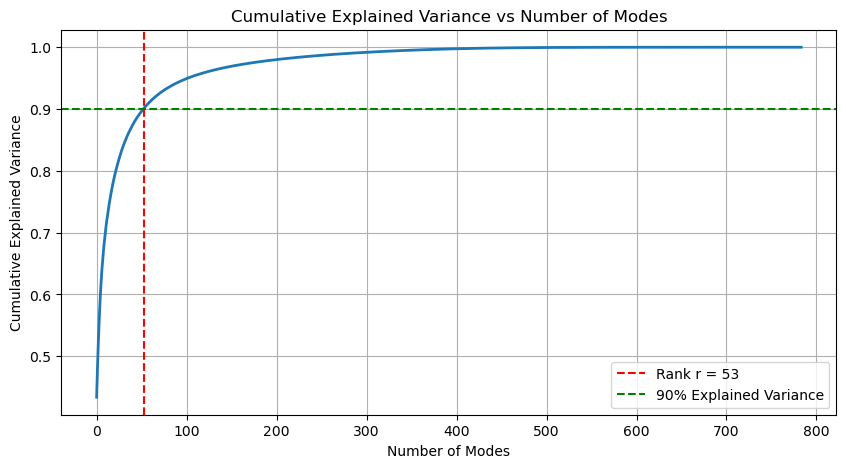

Rank r of the digit space (90% explained variance): 53


In [67]:
# Plot the singular value spectrum
plt.figure(figsize=(10, 5))
plt.plot(s, linewidth=2)
plt.xlabel('Mode')
plt.ylabel('Singular Value')
plt.title('Singular Value Spectrum')
plt.grid()
plt.show()

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(s**2) / np.sum(s**2)

# Find the number of modes necessary for a good image reconstruction
# Here, we use 90% explained variance as the threshold for good image reconstruction
r = np.argmax(cumulative_explained_variance >= 0.9) + 1

# Plot the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, linewidth=2)
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Modes')
plt.axvline(x=r, color='r', linestyle='--', label=f'Rank r = {r}')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Explained Variance')
plt.legend()
plt.grid()
plt.show()

print(f'Rank r of the digit space (90% explained variance): {r}')

What is the interpretation of the U, Σ, and V matrices?

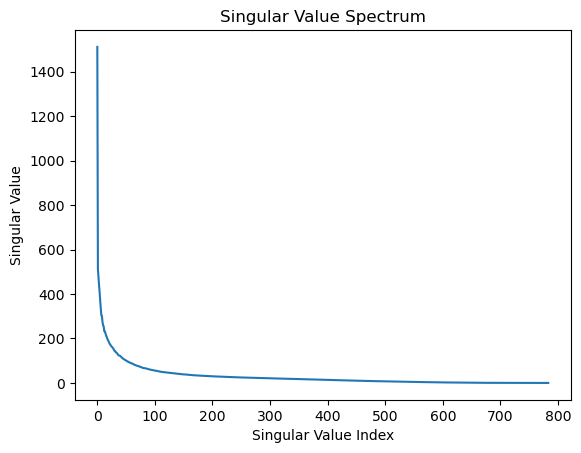

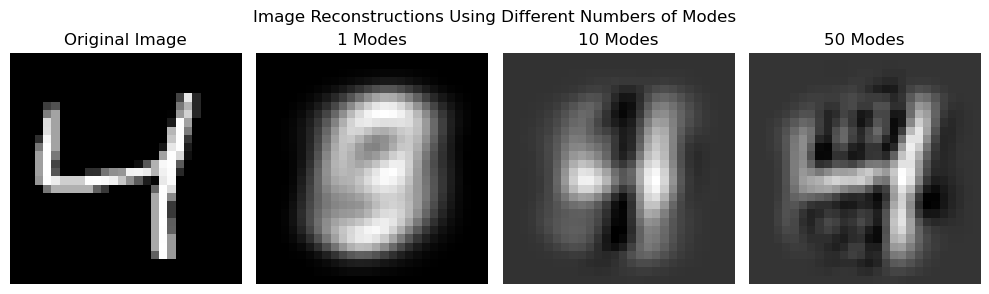

In [68]:
# Plot singular value spectrum
plt.figure()
plt.plot(s)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Value Spectrum')

# Reconstruct some images using the first few singular values and modes
n_modes = [1, 10, 50]
image_idx = 2

fig, axs = plt.subplots(1, len(n_modes) + 1, figsize=(10, 3))
axs[0].imshow(train_images[image_idx], cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original Image')

for i, mode in enumerate(n_modes):
    reconstruction = u[:, :mode] @ np.diag(s[:mode]) @ vh[:mode, :]
    reconstructed_image = reconstruction[:, image_idx].reshape(28, 28)
    axs[i + 1].imshow(reconstructed_image, cmap='gray')
    axs[i + 1].axis('off')
    axs[i + 1].set_title(f'{mode} Modes')

plt.suptitle('Image Reconstructions Using Different Numbers of Modes')
plt.tight_layout()
plt.show()

On a 3D plot, project onto three selected V-modes (columns) colored by their digit label. For
example, columns 2,3, and 5.

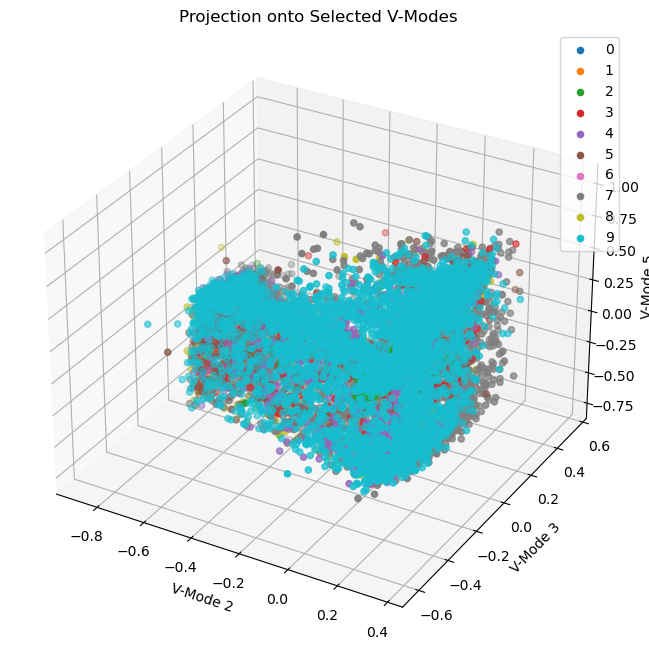

In [69]:
from mpl_toolkits.mplot3d import Axes3D

selected_modes = [1, 2, 4]  # Columns 2, 3, and 5 (0-indexed)
projection = np.dot(train_images_flat.T, vh[:, selected_modes])

# Create a 3D plot colored by digit labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for digit in range(10):
    mask = train_labels == digit
    ax.scatter(projection[mask, 0], projection[mask, 1], projection[mask, 2], label=digit)

ax.set_xlabel(f'V-Mode {selected_modes[0] + 1}')
ax.set_ylabel(f'V-Mode {selected_modes[1] + 1}')
ax.set_zlabel(f'V-Mode {selected_modes[2] + 1}')
ax.set_title('Projection onto Selected V-Modes')
ax.legend()
plt.show()

• Pick two digits. See if you can build a linear classifier (LDA) that can reasonable identify/classify
them.
• Pick three digits. Try to build a linear classifier to identify these three now.

In [70]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Choose two digits to classify, and create a mask to filter the training and testing datasets:
digit1, digit2 = 2, 6

train_mask = (train_labels == digit1) | (train_labels == digit2)
test_mask = (test_labels == digit1) | (test_labels == digit2)

train_images_filtered = train_images[train_mask]
train_labels_filtered = train_labels[train_mask]
test_images_filtered = test_images[test_mask]
test_labels_filtered = test_labels[test_mask]

# Reshape the filtered images into column vectors:
train_images_flat = train_images_filtered.reshape(train_images_filtered.shape[0], -1)
test_images_flat = test_images_filtered.reshape(test_images_filtered.shape[0], -1)

# Train the LDA classifier on the filtered training dataset:
lda = LinearDiscriminantAnalysis()
lda.fit(train_images_flat, train_labels_filtered)

# Test the trained LDA classifier on the filtered testing dataset, and calculate the accuracy:
predictions = lda.predict(test_images_flat)
accuracy = accuracy_score(test_labels_filtered, predictions)

print(f"Accuracy of the LDA classifier on digits {digit1} and {digit2}: {accuracy * 100:.2f}%")



Accuracy of the LDA classifier on digits 2 and 6: 97.89%


LDA classifier accuracy on digits 2 and 6: 97.89%


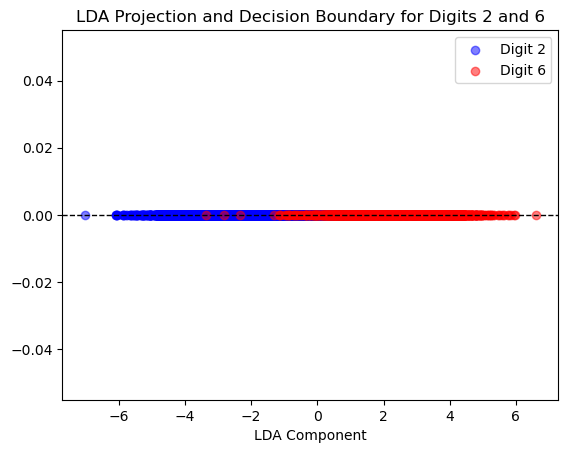

In [71]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
train_images_flat_scaled = scaler.fit_transform(train_images_flat)
test_images_flat_scaled = scaler.transform(test_images_flat)

# Perform LDA on the scaled data
X_train_lda = lda.fit_transform(train_images_flat_scaled, train_labels_filtered)
X_test_lda = lda.transform(test_images_flat_scaled)

# Calculate the accuracy on the test set
lda_accuracy = lda.score(test_images_flat_scaled, test_labels_filtered)
print(f"LDA classifier accuracy on digits {digit1} and {digit2}: {lda_accuracy * 100:.2f}%")

# Plot the dataset projected onto the first LDA component with the decision boundary
plt.figure()
colors = ['b', 'r']
for digit, color in zip([digit1, digit2], colors):
    plt.scatter(X_train_lda[train_labels_filtered == digit, 0], np.zeros(np.sum(train_labels_filtered == digit)), c=color, alpha=0.5, label=f"Digit {digit}")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('LDA Component')
plt.title(f'LDA Projection and Decision Boundary for Digits {digit1} and {digit2}')
plt.legend()
plt.show()

In [72]:
# Choose three digits to classify, and create a mask to filter the training and testing datasets:
digit1, digit2, digit3 = 2, 6, 7

train_mask = (train_labels == digit1) | (train_labels == digit2) | (train_labels == digit3)
test_mask = (test_labels == digit1) | (test_labels == digit2) | (test_labels == digit3)

train_images_filtered = train_images[train_mask]
train_labels_filtered = train_labels[train_mask]
test_images_filtered = test_images[test_mask]
test_labels_filtered = test_labels[test_mask]

# Reshape the filtered images into column vectors:
train_images_flat = train_images_filtered.reshape(train_images_filtered.shape[0], -1)
test_images_flat = test_images_filtered.reshape(test_images_filtered.shape[0], -1)

# Train the LDA classifier on the filtered training dataset:
lda = LinearDiscriminantAnalysis()
lda.fit(train_images_flat, train_labels_filtered)

# Test the trained LDA classifier on the filtered testing dataset, and calculate the accuracy:
predictions = lda.predict(test_images_flat)
accuracy = accuracy_score(test_labels_filtered, predictions)

print(f"Accuracy of the LDA classifier on digits {digit1}, {digit2}, and {digit3}: {accuracy * 100:.2f}%")

Accuracy of the LDA classifier on digits 2, 6, and 7: 96.72%


LDA classifier accuracy on digits 2, 6, and 7: 96.72%


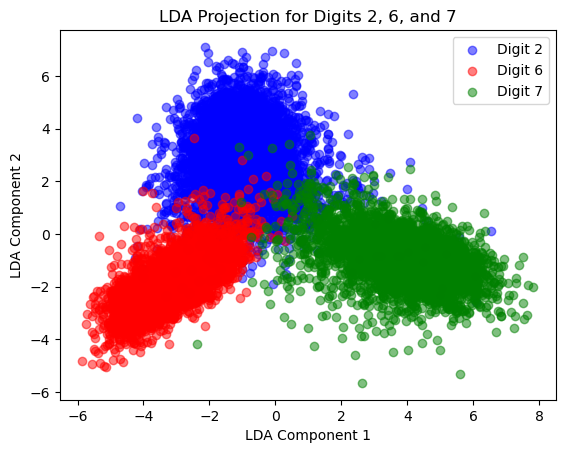

In [73]:
# Scale the data
scaler = StandardScaler()
train_images_flat_scaled = scaler.fit_transform(train_images_flat)
test_images_flat_scaled = scaler.transform(test_images_flat)

# Perform LDA on the scaled data
X_train_lda = lda.fit_transform(train_images_flat_scaled, train_labels_filtered)
X_test_lda = lda.transform(test_images_flat_scaled)

# Calculate the accuracy on the test set
lda_accuracy = lda.score(test_images_flat_scaled, test_labels_filtered)
print(f"LDA classifier accuracy on digits {digit1}, {digit2}, and {digit3}: {lda_accuracy * 100:.2f}%")

# Plot the dataset projected onto the LDA components
plt.figure()
colors = ['b', 'r', 'g']
for digit, color in zip([digit1, digit2, digit3], colors):
    plt.scatter(X_train_lda[train_labels_filtered == digit, 0], X_train_lda[train_labels_filtered == digit, 1], c=color, alpha=0.5, label=f"Digit {digit}")
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title(f'LDA Projection for Digits {digit1}, {digit2}, and {digit3}')
plt.legend()
plt.show()

Which two digits in the data set appear to be the most difficult to separate? Quantify the accuracy
of the separation with LDA on the test data.

Which two digits in the data set are most easy to separate? Quantify the accuracy of the separation
with LDA on the test data.

In [27]:
# Define a function to calculate the LDA classification accuracy for a given pair of digits:
def lda_accuracy(digit1, digit2, train_images, train_labels, test_images, test_labels):
    train_mask = (train_labels == digit1) | (train_labels == digit2)
    test_mask = (test_labels == digit1) | (test_labels == digit2)

    train_images_filtered = train_images[train_mask]
    train_labels_filtered = train_labels[train_mask]
    test_images_filtered = test_images[test_mask]
    test_labels_filtered = test_labels[test_mask]

    train_images_flat = train_images_filtered.reshape(train_images_filtered.shape[0], -1)
    test_images_flat = test_images_filtered.reshape(test_images_filtered.shape[0], -1)

    lda = LinearDiscriminantAnalysis()
    lda.fit(train_images_flat, train_labels_filtered)

    predictions = lda.predict(test_images_flat)
    accuracy = accuracy_score(test_labels_filtered, predictions)

    return accuracy

In [29]:
# Iterate through all possible digit pairs, calculate the LDA classification accuracy, 
# and find the pair with the lowest accuracy:
min_accuracy = 1.0
min_digit_pair = None

for i in range(10):
    for j in range(i + 1, 10):
        accuracy = lda_accuracy(i, j, train_images, train_labels, test_images, test_labels)
        if accuracy < min_accuracy:
            min_accuracy = accuracy
            min_digit_pair = (i, j)

print(f"The most difficult digits to separate are {min_digit_pair[0]} and {min_digit_pair[1]}, with an accuracy of {min_accuracy * 100:.2f}%.")

The most difficult digits to separate are 5 and 8, with an accuracy of 95.12%.


In [30]:
# Iterate through all possible digit pairs, calculate the LDA classification accuracy,
# and find the pair with the highest accuracy:
max_accuracy = 0.0
max_digit_pair = None

for i in range(10):
    for j in range(i + 1, 10):
        accuracy = lda_accuracy(i, j, train_images, train_labels, test_images, test_labels)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_digit_pair = (i, j)

print(f"The easiest digits to separate are {max_digit_pair[0]} and {max_digit_pair[1]}, with an accuracy of {max_accuracy * 100:.2f}%.")

The easiest digits to separate are 6 and 9, with an accuracy of 99.59%.


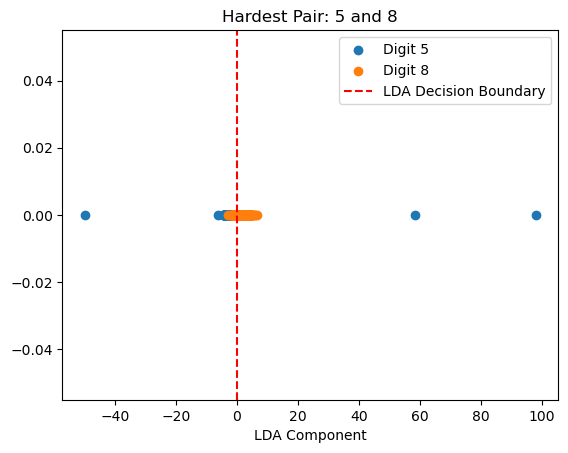

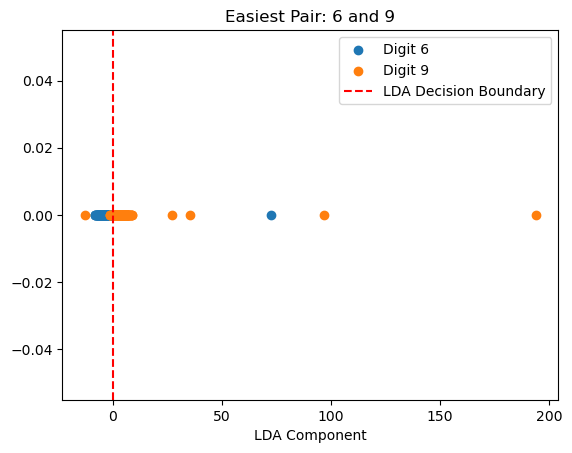

In [77]:
# Here is the code for plotting the LDA decision boundary for both the hardest and easiest pairs of digits:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_lda_boundary(train_images, train_labels, test_images, test_labels, digit1, digit2, title):
    mask_train = (train_labels == digit1) | (train_labels == digit2)
    mask_test = (test_labels == digit1) | (test_labels == digit2)

    train_images_filtered = train_images[mask_train]
    train_labels_filtered = train_labels[mask_train]
    test_images_filtered = test_images[mask_test]
    test_labels_filtered = test_labels[mask_test]

    train_images_flat = train_images_filtered.reshape(train_images_filtered.shape[0], -1)
    test_images_flat = test_images_filtered.reshape(test_images_filtered.shape[0], -1)

    lda = LinearDiscriminantAnalysis()
    lda.fit(train_images_flat, train_labels_filtered)

    transformed_data = lda.transform(test_images_flat)

    plt.figure()
    plt.scatter(transformed_data[test_labels_filtered == digit1], [0] * len(transformed_data[test_labels_filtered == digit1]), label=f"Digit {digit1}")
    plt.scatter(transformed_data[test_labels_filtered == digit2], [0] * len(transformed_data[test_labels_filtered == digit2]), label=f"Digit {digit2}")
    plt.axvline(x=0, color='red', linestyle='--', label='LDA Decision Boundary')
    plt.xlabel('LDA Component')
    plt.title(title)
    plt.legend()
    plt.show()

plot_lda_boundary(train_images, train_labels, test_images, test_labels, hardest_digits[0], hardest_digits[1], f"Hardest Pair: {hardest_digits[0]} and {hardest_digits[1]}")
plot_lda_boundary(train_images, train_labels, test_images, test_labels, easiest_digits[0], easiest_digits[1], f"Easiest Pair: {easiest_digits[0]} and {easiest_digits[1]}")

SVM (support vector machines) and decision tree classifiers were the state-of-the-art until about 2014. How well do these separate between all ten digits?

In [55]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape each image into a column vector
train_images_flat = train_images.reshape(train_images.shape[0], -1).T
test_images_flat = test_images.reshape(test_images.shape[0], -1).T

# Train SVM classifier on training data
svm = svm.SVC()
svm.fit(train_images_flat.T, train_labels)

# Calculate accuracy of SVM classifier on test data
# Use SVM classifier to predict labels on test data
svm_predictions = svm.predict(test_images_flat.T)
svm_accuracy = accuracy_score(test_labels, svm_predictions)

print(f"SVM classifier accuracy on all ten digits: {svm_accuracy * 100:.2f}%")

SVM classifier accuracy on all ten digits: 97.92%


In [56]:
# Train and test a Decision Tree classifier on the dataset:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_images_flat.T, train_labels)

dt_predictions = decision_tree.predict(test_images_flat.T)
dt_accuracy = accuracy_score(test_labels, dt_predictions)

print(f"Decision Tree classifier accuracy on all ten digits: {dt_accuracy * 100:.2f}%")

Decision Tree classifier accuracy on all ten digits: 87.83%


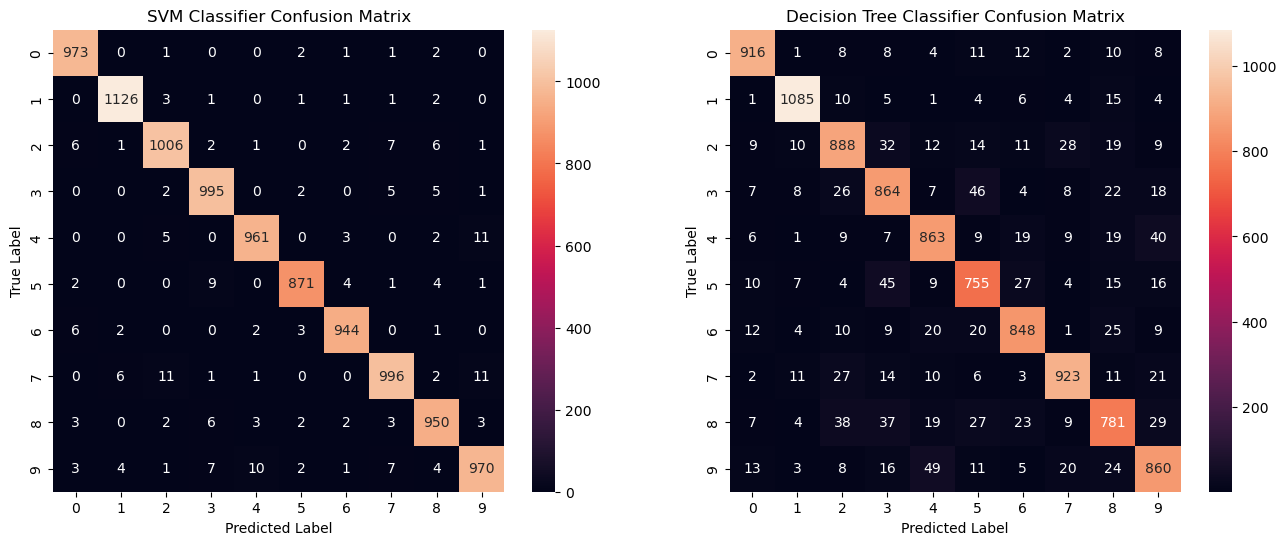

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Compute confusion matrices for both classifiers
svm_confusion_matrix = confusion_matrix(test_labels, svm_predictions)
dt_confusion_matrix = confusion_matrix(test_labels, dt_predictions)

# Plot confusion matrices as heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='d', ax=ax1)
ax1.set_title('SVM Classifier Confusion Matrix')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

sns.heatmap(dt_confusion_matrix, annot=True, fmt='d', ax=ax2)
ax2.set_title('Decision Tree Classifier Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.show()

In [74]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

def evaluate_classifiers(digit1, digit2, train_images, train_labels, test_images, test_labels):
    train_mask = (train_labels == digit1) | (train_labels == digit2)
    test_mask = (test_labels == digit1) | (test_labels == digit2)

    train_images_filtered = train_images[train_mask]
    train_labels_filtered = train_labels[train_mask]
    test_images_filtered = test_images[test_mask]
    test_labels_filtered = test_labels[test_mask]

    train_images_flat = train_images_filtered.reshape(train_images_filtered.shape[0], -1)
    test_images_flat = test_images_filtered.reshape(test_images_filtered.shape[0], -1)

    # Create classifiers
    lda = LinearDiscriminantAnalysis()
    svm = SVC()
    dt = DecisionTreeClassifier()

    # Train classifiers
    lda.fit(train_images_flat, train_labels_filtered)
    svm.fit(train_images_flat, train_labels_filtered)
    dt.fit(train_images_flat, train_labels_filtered)

    # Test classifiers
    lda_predictions = lda.predict(test_images_flat)
    svm_predictions = svm.predict(test_images_flat)
    dt_predictions = dt.predict(test_images_flat)

    # Calculate accuracies
    lda_accuracy = accuracy_score(test_labels_filtered, lda_predictions)
    svm_accuracy = accuracy_score(test_labels_filtered, svm_predictions)
    dt_accuracy = accuracy_score(test_labels_filtered, dt_predictions)

    return lda_accuracy, svm_accuracy, dt_accuracy

In [75]:
# Hardest pair of digits to separate
hardest_digits = min_digit_pair
lda_accuracy, svm_accuracy, dt_accuracy = evaluate_classifiers(*hardest_digits, train_images, train_labels, test_images, test_labels)

print(f"Classifier performance on hardest pair of digits to separate ({hardest_digits[0]} and {hardest_digits[1]}):")
print(f"LDA accuracy: {lda_accuracy * 100:.2f}%")
print(f"SVM accuracy: {svm_accuracy * 100:.2f}%")
print(f"Decision Tree accuracy: {dt_accuracy * 100:.2f}%\n")

# Easiest pair of digits to separate
easiest_digits = max_digit_pair
lda_accuracy, svm_accuracy, dt_accuracy = evaluate_classifiers(*easiest_digits, train_images, train_labels, test_images, test_labels)

print(f"Classifier performance on easiest pair of digits to separate ({easiest_digits[0]} and {easiest_digits[1]}):")
print(f"LDA accuracy: {lda_accuracy * 100:.2f}%")
print(f"SVM accuracy: {svm_accuracy * 100:.2f}%")
print(f"Decision Tree accuracy: {dt_accuracy * 100:.2f}%")

Classifier performance on hardest pair of digits to separate (5 and 8):
LDA accuracy: 95.12%
SVM accuracy: 99.57%
Decision Tree accuracy: 96.89%

Classifier performance on easiest pair of digits to separate (6 and 9):
LDA accuracy: 99.59%
SVM accuracy: 99.90%
Decision Tree accuracy: 99.59%


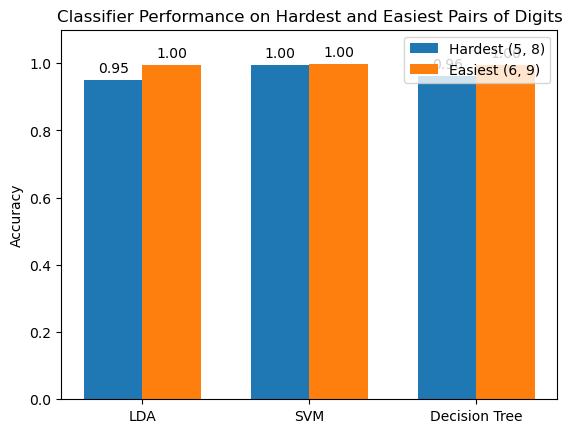

In [76]:
import matplotlib.pyplot as plt

def plot_accuracies(hardest_digits, easiest_digits, hardest_accuracies, easiest_accuracies):
    labels = ['LDA', 'SVM', 'Decision Tree']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, hardest_accuracies, width, label=f'Hardest ({hardest_digits[0]}, {hardest_digits[1]})')
    rects2 = ax.bar(x + width/2, easiest_accuracies, width, label=f'Easiest ({easiest_digits[0]}, {easiest_digits[1]})')

    ax.set_ylabel('Accuracy')
    ax.set_title('Classifier Performance on Hardest and Easiest Pairs of Digits')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.ylim(0, 1.1)
    plt.show()

# Get the accuracies for the hardest and easiest pairs of digits
hardest_accuracies = evaluate_classifiers(*hardest_digits, train_images, train_labels, test_images, test_labels)
easiest_accuracies = evaluate_classifiers(*easiest_digits, train_images, train_labels, test_images, test_labels)

# Plot the accuracies
plot_accuracies(hardest_digits, easiest_digits, hardest_accuracies, easiest_accuracies)